# 0. Imports and data loading

All packages and modules are imported in the "functions.py" file located next to this notebook

Additionally a number of code chunks employed in previous and more rough versions of this notebook have been
defined as functions and placed in that same file in order to simplify the exposition of the 
main points and results of the assignment. For further insight on the code behind the actions
here executed this "functions.py" file can be visited, there all the details can be found.

IMPORTANT: for the appropriate functioning of this notebook it must be placed in the same 
directory as "functions.py"

In [1]:
from functions import *

In [7]:
features = np.load('/content/drive/MyDrive/newdata/data.npy')
labels = np.load('/content/drive/MyDrive/newdata/labels.npy')

# 1. Elemental data preprocessing



### 1.1 Splitting Data

Here the dataset splits with ratios of 0.2 and a random state of 42, and stratification so the proportion of values is maintained in the sliced sets.

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

### 1.2 Normalize Data

In [9]:
# Float conversion to allow normalization
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_val=X_val.astype('float32')

# Normalization 
X_train=X_train/255.0
X_test=X_test/255.0
X_val=X_val/255.0

### 1.3 Categorical encoding

In [10]:
# Define a dictionary that maps each category to a numerical value
label_map = {"Bacterial Pneumonia": 0, "Viral Pneumonia": 1, "No Pneumonia (healthy)": 2, "COVID-19": 3}

# Encode the categorical labels as numerical values using the label map
y_train_encoded = np.vectorize(label_map.get)(y_train)
y_val_encoded = np.vectorize(label_map.get)(y_val)
y_test_encoded = np.vectorize(label_map.get)(y_test)

# Convert the numerical labels to one-hot encoded format
num_classes = 4
y_train_onehot = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# 2. Baseline Model

### 2.1 Build and train baseline model

In [12]:
baseline_model = build_baseline_model()

# Train the model for 10 epochs with a batch size of 32
history = baseline_model.fit(
    X_train,
    y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val_onehot)
)

Epoch 1/10
130/130 [==============================] - 23s 75ms/step - loss: 0.9259 - accuracy: 0.5913 - val_loss: 0.7869 - val_accuracy: 0.6703
Epoch 2/10
130/130 [==============================] - 7s 58ms/step - loss: 0.6653 - accuracy: 0.7022 - val_loss: 0.6801 - val_accuracy: 0.7021
Epoch 3/10
130/130 [==============================] - 8s 63ms/step - loss: 0.5922 - accuracy: 0.7357 - val_loss: 0.6454 - val_accuracy: 0.7021
Epoch 4/10
130/130 [==============================] - 7s 57ms/step - loss: 0.5592 - accuracy: 0.7478 - val_loss: 0.6510 - val_accuracy: 0.7086
Epoch 5/10
130/130 [==============================] - 8s 58ms/step - loss: 0.5077 - accuracy: 0.7709 - val_loss: 0.6829 - val_accuracy: 0.6992
Epoch 6/10
130/130 [==============================] - 8s 59ms/step - loss: 0.4612 - accuracy: 0.7866 - val_loss: 0.7399 - val_accuracy: 0.7021
Epoch 7/10
130/130 [==============================] - 8s 62ms/step - loss: 0.4006 - accuracy: 0.8054 - val_loss: 0.7619 - val_accuracy: 0.680

In [13]:
baseline_all_val_acc = np.mean(history.history["val_accuracy"])
baseline_all_val_loss = np.mean(history.history["val_loss"])
baseline_all_train_acc = np.mean(history.history["accuracy"])
baseline_all_train_loss = np.mean(history.history["loss"])
print("BASELINE RESULTS:")
print("-"*len("BASELINE RESULTS:"))
print()
print("**Training**")
print("The average training accuracy among all epochs is: {:.4}".format(baseline_all_train_acc))
print("The average training loss among all epochs is: {:.4}".format(baseline_all_train_loss))
print()
print("**Validation**")
print("The average validation accuracy among all epochs is: {:.4}".format(baseline_all_val_acc))
print("The average validation loss among all epochs is: {:.4}".format(baseline_all_val_loss))

BASELINE RESULTS:
-----------------

**Training**
The average training accuracy among all epochs is: 0.7721
The average training loss among all epochs is: 0.4998

**Validation**
The average validation accuracy among all epochs is: 0.6886
The average validation loss among all epochs is: 0.7879


### 2.2 Analyze the performance of the baseline model

The baseline model will be analysed by plots. The plot of accuracy and loss by epochs of training vs validation. Given the precision of the target variable, plot of ROC curve with its respective areas. The plot of the confusion matrix. Also, a table of the precision, recall and f1-score, and accuracy. 

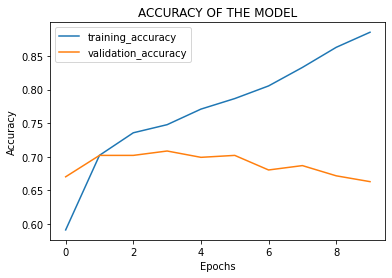

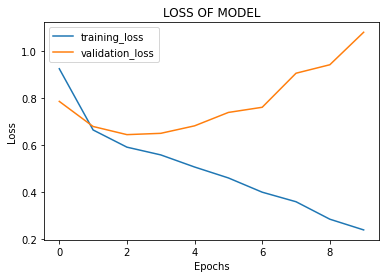

44/44 [==============================] - 1s 18ms/step


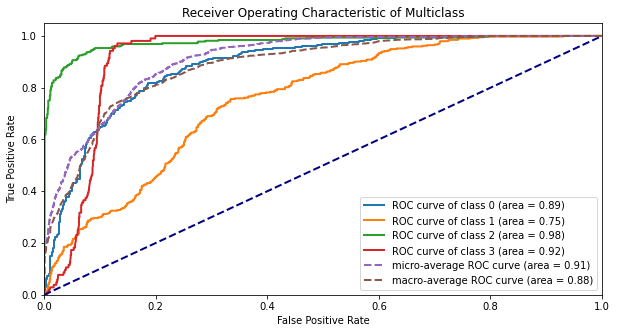

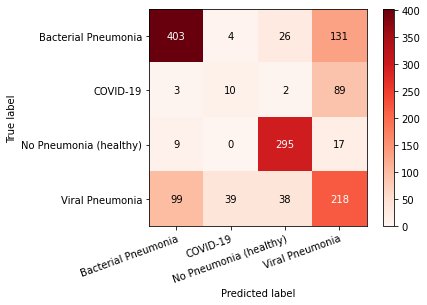

                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.78      0.71      0.75       564
              COVID-19       0.19      0.10      0.13       104
No Pneumonia (healthy)       0.82      0.92      0.87       321
       Viral Pneumonia       0.48      0.55      0.51       394

              accuracy                           0.67      1383
             macro avg       0.57      0.57      0.56      1383
          weighted avg       0.66      0.67      0.66      1383



In [14]:
##------ploting from BASELINE only 

plot_acc_loss(history)

##----Getting prediction based in the baseline model 
y_pred = baseline_model.predict(X_test) 

#-------Plot ROC of the baselinemodel 
plot_ROC_curve(y_pred,y_test_onehot, num_classes)

##----CM Matrix plot
plot_cm(label_map,y_pred,y_test)

#precision and recall and f1-score, accuracy 
table_p_r_f1(y_test,y_pred,label_map)

# 3. Adapting/fine-tuning the network

### 3.1 Data augmentation/random subsampling

Alongside the different tuning and performance enhancing techniques applied to elaborate the network, additional data processing was implemented aiming at achieving higher performance. 

In that sense a data augmentation mechanism was implemented where the sample was enlarged by including flipped and rotated versions of the instances. Additionally, this mechanism was designed in such a way that it also helped tackling class imbalance by augmenting the instances belonging to the COVID-19 class to a larger extent compared to the other one such that both goals are achieved at the same time: address class imbalance and augment the dataset.

Moreover a mechanism of random subsampling was also incorporated to allow testing the different models at a fraction of the computational cost. Data subsampling also considers class imbalance when carried out.

In [15]:
#############################################
#             CONTROL PANEL (Fine tuning)

# Random Subsampling
restriction = True
address_vp_imbalance = True
proportion = 0.25

# Data Augmentation
augmentation_flip = False                       
augmentation_rotate = False

#                                           
#############################################


# Safety mechanism: augmentation and subsampling are not meant to be combined
if restriction == True:
    agumentation_flip = False
    augmentation_rotate = False

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [17]:
if restriction == True:
    
    if address_vp_imbalance == True:
        restricted_sample_train, restricted_sample_labels_train = restrict_sample_vp_imb(proportion , X_train, y_train)
        generate_summary("R", y_train, restricted_sample_labels_train)
        X_train = np.array(restricted_sample_train)
        y_train = np.array(restricted_sample_labels_train)
        
    else:
        restricted_sample_train, restricted_sample_labels_train = restrict_sample(proportion , X_train, y_train)
        generate_summary("R", y_train, restricted_sample_labels_train)
        X_train = np.array(restricted_sample_train)
        y_train = np.array(restricted_sample_labels_train)

elif augmentation_flip == True:

    augmentedfeatures, augmentedlabels = augment_sample(X_train, y_train, a_rotate=augmentation_rotate)
    generate_summary("R", y_train, augmentedlabels)
    X_train = np.array(augmentedfeatures)
    y_train = np.array(augmentedlabels)
    
else:
    print("NEITHER RANDOM SUBSAMPLING NOR AUGMENTATION WERE NOT CONDUCTED")

SAMPLE RESTRICTION SUMMARY
(Only covering training sample)


ORIGINAL TRAINING SAMPLE
Original number of instances: 4147
Original instance distribution by class: 
 Bacterial Pneumonia       1689
Viral Pneumonia           1182
No Pneumonia (healthy)     963
COVID-19                   313
dtype: int64

NEW TRAINING SAMPLE
Number of instances in new sample: 1408
Instance distribution by class in new sample: 
 Viral Pneumonia           433
Bacterial Pneumonia       422
COVID-19                  313
No Pneumonia (healthy)    240
dtype: int64


### 3.2 Categorical encoding of new labels

In [18]:
# Float conversion to allow normalization
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_val=X_val.astype('float32')

# Normalization 
X_train=X_train/255.0
X_test=X_test/255.0
X_val=X_val/255.0

In [19]:
# Define a dictionary that maps each category to a numerical value
label_map = {"Bacterial Pneumonia": 0, "Viral Pneumonia": 1, "No Pneumonia (healthy)": 2, "COVID-19": 3}

# Encode the categorical labels as numerical values using the label map
y_train_encoded = np.vectorize(label_map.get)(y_train)

# Convert the numerical labels to one-hot encoded format
num_classes = 4
y_train_onehot = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

### 3.3 Network fine tuning

#### 3.3.1. Learning Rate Scheduling

We tried to implement a learning rate sheduling for "SGD" optimizer using the baseline model as a starting point, however later on, "Adam" and "Nadam" performed better in validation loss and accuracy, so we discarded it.

Note: The functions in the following cell are still here due to some trouble running the code when importing them from "functions.py"

In [26]:
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt

def lr_schedule(epoch, initial_lr, final_lr, total_epochs):
    """
    calculates the learning rate for each epoch based on the initial learning rate, final learning rate, and total number of epochs
    """
    lr = initial_lr + (final_lr - initial_lr) * (epoch / float(total_epochs))
    return lr

def plot_lr_schedule(initial_lr, final_lr, total_epochs):
    lr = [lr_schedule(epoch, initial_lr, final_lr, total_epochs) for epoch in range(total_epochs)]
    plt.plot(lr, history.history['val_loss'])
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Loss')
    plt.title('Learning Rate Schedule')
    plt.show()

# Adding a Lr Scheduler to check the learning rate evolution during training and to avoid overfitting
initial_lr = 0.001
final_lr = 0.01
baseline_epochs = 10

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch, initial_lr, final_lr, baseline_epochs))

baseline_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Train the model for 4 epochs with a batch size of 32
history_lr = baseline_model.fit(
    X_train,
    y_train_onehot,
    batch_size=32,
    epochs=baseline_epochs,
    validation_data=(X_val, y_val_onehot),
    callbacks=[lr_scheduler]
)

Epoch 1/10
44/44 [==============================] - 9s 102ms/step - loss: 1.3599 - accuracy: 0.2997 - val_loss: 1.3482 - val_accuracy: 0.4071 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 3s 65ms/step - loss: 1.3599 - accuracy: 0.2898 - val_loss: 1.3484 - val_accuracy: 0.2849 - lr: 0.0019
Epoch 3/10
44/44 [==============================] - 3s 80ms/step - loss: 1.3599 - accuracy: 0.2926 - val_loss: 1.3487 - val_accuracy: 0.2849 - lr: 0.0028
Epoch 4/10
44/44 [==============================] - 3s 69ms/step - loss: 1.3599 - accuracy: 0.3075 - val_loss: 1.3490 - val_accuracy: 0.2849 - lr: 0.0037
Epoch 5/10
44/44 [==============================] - 3s 65ms/step - loss: 1.3599 - accuracy: 0.3011 - val_loss: 1.3494 - val_accuracy: 0.2849 - lr: 0.0046
Epoch 6/10
44/44 [==============================] - 3s 65ms/step - loss: 1.3599 - accuracy: 0.3075 - val_loss: 1.3498 - val_accuracy: 0.2849 - lr: 0.0055
Epoch 7/10
44/44 [==============================] - 4s 80ms/step - loss: 1.

As we can see in the following graph, the learning rate started to climb down around 0.006/0.007. 
Hence, if we were using SGD optimizer, a value between these numbers could be a good learning rate for the baseline model.

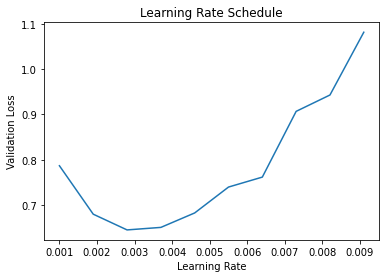

In [27]:
plot_lr_schedule(initial_lr, final_lr, baseline_epochs)

We ran the following cell sometimes in order to clean up memory and speed up the process.

In [28]:
"""from keras import backend as K

# Some memory clean-up
K.clear_session()"""

'from keras import backend as K\n\n# Some memory clean-up\nK.clear_session()'

#### 3.3.2. K-Fold Cross Validation

- We implemented K-Fold Cross Validation for the tuned model (check functions.py to see its structure). 
- We also reused the baseline model here in order to have a comparison of how it could be improved using K-Fold CV (k=4 for an efficient computation).
- Note: Observe we added to the tuned model an "EarlyStopping" callback to monitor validation loss. If the error kept going up after 2 epochs, it would stop (patience = 2). However, when running the notebook for the submission, we set patience = 10 to have same number of epochs as the baseline.

In [29]:
# K FOLD VALIDATION (4 max epochs for speeding purposes)

k = 4
num_val_samples = len(X_train) // k 
num_epochs = 10
tuned_all_val_losses = [] # Should add the score of each run at the end of the loop
tuned_all_val_acc = []
base_all_val_losses = []
base_all_val_acc = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = y_train_onehot[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_onehot[:i * num_val_samples],
         y_train_onehot[(i + 1) * num_val_samples:]],
        axis=0)
    # (CHANGE VS BASELINE)Defining EarlyStopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    baseline_model = build_baseline_model()
    tuned_model_1 = build_tuned_model()

    # Train baseline and tuned models for 4 epochs with a batch size of 32
    print('processing baseline model')
    baseline_history = baseline_model.fit(
        partial_train_data,
        partial_train_targets,
        batch_size=32,
        epochs=num_epochs,
        validation_data=(val_data, val_targets),
    )
    print('processing tuned model')
    tuned_history = tuned_model_1.fit(
        partial_train_data,
        partial_train_targets,
        batch_size=32,
        epochs=num_epochs,
        validation_data=(val_data, val_targets),
        callbacks=[early_stopping]
    )
   
    # Evaluate the kfold results for BASELINE
    base_val_loss, base_val_accuracy = baseline_model.evaluate(val_data, val_targets, verbose=0)
    base_all_val_losses.append(base_val_loss)
    base_all_val_acc.append(base_val_accuracy)

    # Evaluate the kfold results for the tuned model
    tuned_val_loss, tuned_val_accuracy = tuned_model_1.evaluate(val_data, val_targets, verbose=0)
    tuned_all_val_losses.append(tuned_val_loss)
    tuned_all_val_acc.append(tuned_val_accuracy)

processing fold # 0
processing baseline model
Epoch 1/10
33/33 [==============================] - 7s 72ms/step - loss: 1.3505 - accuracy: 0.3087 - val_loss: 1.2494 - val_accuracy: 0.3608
Epoch 2/10
33/33 [==============================] - 2s 59ms/step - loss: 1.1790 - accuracy: 0.4706 - val_loss: 1.1750 - val_accuracy: 0.4545
Epoch 3/10
33/33 [==============================] - 2s 54ms/step - loss: 1.0323 - accuracy: 0.5634 - val_loss: 0.9731 - val_accuracy: 0.5881
Epoch 4/10
33/33 [==============================] - 2s 60ms/step - loss: 0.9151 - accuracy: 0.6146 - val_loss: 0.9417 - val_accuracy: 0.5966
Epoch 5/10
33/33 [==============================] - 2s 61ms/step - loss: 0.7942 - accuracy: 0.6676 - val_loss: 0.8754 - val_accuracy: 0.6108
Epoch 6/10
33/33 [==============================] - 2s 62ms/step - loss: 0.7644 - accuracy: 0.6515 - val_loss: 0.8935 - val_accuracy: 0.6165
Epoch 7/10
33/33 [==============================] - 2s 61ms/step - loss: 0.7200 - accuracy: 0.6847 - val_los

- As you can see, KFold improved baseline average validation accuracy by 6% and decreased by 6.8% the validation error.
- Also, tuned model performed around 1.1% better against the baseline model (with data restricted to 25%) in the average accuracy of the validation set. It also has around 5% less average validation error than the baseline model.

In [30]:
print("Baseline Model KF Results:")
print("-"*len("Baseline Model Results:"))
print("Avg val_acc: {}".format(np.mean(base_all_val_acc)))
print("Avg val_loss: {}".format(np.mean(base_all_val_losses)))
print()
print("Tuned Model KF Results:")
print("-"*len("Tuned Model KF Results:"))
print("Avg val_acc: {}".format(np.mean(tuned_all_val_acc)))
print("Avg val_loss: {}".format(np.mean(tuned_all_val_losses)))

Baseline Model KF Results:
-----------------------
Avg val_acc: 0.6512784063816071
Avg val_loss: 0.9140058755874634

Tuned Model KF Results:
-----------------------
Avg val_acc: 0.6875000149011612
Avg val_loss: 0.7383667528629303


### 3.4 Analyze performance of fine-tuned model

The fine-tuned model will be analysed by plots. The plot of accuracy and loss by epochs of training vs validation. Given the precision of the target variable, plot of ROC curve with its respective areas. The plot of the confusion matrix. Also, a table of the precision, recall and f1-score, and accuracy. 

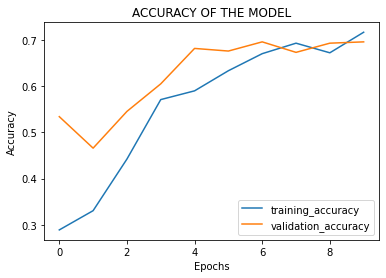

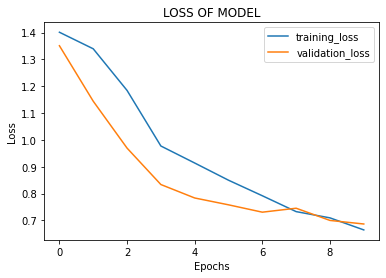

44/44 [==============================] - 1s 29ms/step


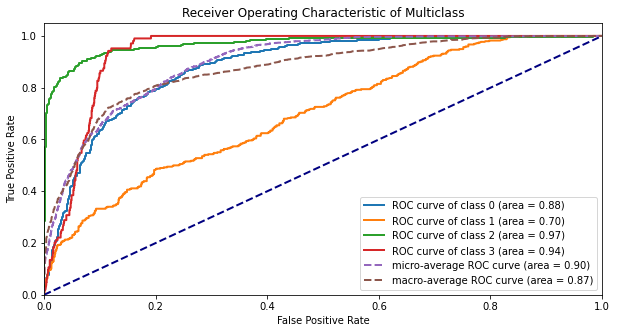

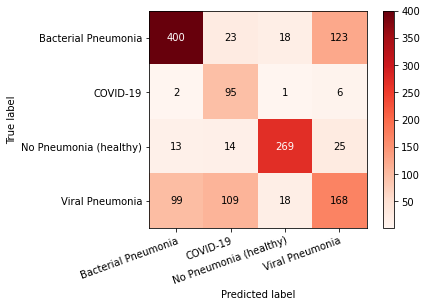

                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.78      0.71      0.74       564
              COVID-19       0.39      0.91      0.55       104
No Pneumonia (healthy)       0.88      0.84      0.86       321
       Viral Pneumonia       0.52      0.43      0.47       394

              accuracy                           0.67      1383
             macro avg       0.64      0.72      0.66      1383
          weighted avg       0.70      0.67      0.68      1383



In [31]:
##------ploting from BASELINE only 
plot_acc_loss(tuned_history)

##----Getting prediction based in the baseline model 
y_pred = tuned_model_1.predict(X_test) 

#-------Plot ROC of the baselinemodel 
plot_ROC_curve(y_pred,y_test_onehot, num_classes)

##----CM Matrix plot
plot_cm(label_map,y_pred,y_test)

#precision and recall and f1-score, accuracy 
table_p_r_f1(y_test,y_pred,label_map)

### 3.5 Grid search / Finding the best parameters

The purpose of this grid search was to find the optimal alpha values for the LeakyReLUs of the tuned model.

This experiment was conducted for a previous version of the tuned model above, which was the one with the best performance among all those that were built during the assignment.

First, a dictionary param_grid is defined to specify the hyperparameters to test. This includes five hyperparameters (alpha1, alpha2, alpha3, alpha4, and alpha5) with two values each to test (0.1 and 0.01).Next, a KerasClassifier is created using the build_optimized_model function. This function is used to define the architecture of the neural network and compile it with an optimizer and loss function. Then, a GridSearchCV object is created with the KerasClassifier and the param_grid dictionary. The cv parameter specifies the  number of cross-validation folds to use. Finally, the fit method is called on the GridSearchCV object with the training data (X_train_norm and y_train_onehot). This trains multiple Keras models with different hyperparameters and evaluates their performance using cross-validation. The best hyperparameters are selected based on the average performance across all cross-validation folds.

The results of the grid search are printed with the best score and best hyperparameters.


#### 3.5.1 Grid Search for hyperparameter alpha (LeakyReLU)

In [ ]:
# Train the model for 10 epochs with a batch size of 32
# Define the hyperparameters to test
param_grid = {
    'alpha1': [0.1, 0.01],
    'alpha2': [0.1, 0.01],
    'alpha3': [0.1, 0.01],
    'alpha4': [0.1, 0.01],
    'alpha5': [0.1, 0.01]
}

# Create a KerasClassifier with the create_model function
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_optimized_model, epochs=1, batch_size=32)

# Perform a grid search to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train_onehot)

# Print the results of the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

First, an Optuna study object is defined with the create_study function. The direction parameter specifies whether to minimize the objective function.
Next, the optimize method is called on the study object with the objective function and the n_trials parameter. This performs a specified number of trials to search for the best
hyperparameters.

After the optimization process is complete, the best hyperparameters found by Optuna are printed with the study.best_params attribute.

Then, a Keras model is created using the create_model function with the best trial found by Optuna. This function is not shown in the code snippet provided.

Finally, the best model is trained for 10 epochs using the fit method with the normalized training data (X_train_norm and y_train_onehot) and validation data 
(X_val_norm and y_val_onehot). The batch_size and epochs parameters are specified here, but the optimizer and loss function used to compile the model are defined elsewhere
 in the code. The training history is stored in the best_history variable


#### 3.5.2 Optuna optimization for filters and kernel size

In [ ]:
### Optuna optimization

# Define the study
study = optuna.create_study(direction='minimize')

# Start the optimization process
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print(f'Best hyperparameters: {study.best_params}')

# Create the best model
best_model = create_model(study.best_trial)

# Train the best model for 10 epochs
best_history = best_model.fit(
    X_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_norm, y_val_onehot)
)

# 4. Transfer Learning

### 4.1 VGG16

#### 4.1.1 Transfer learning with VGG16

The first transfer learning excercise conducted takes advantage of a pre-trained VGG16 architecture. The convolutional segment of the model is imported while the final fully-conected and output layers adapted to the task at hand are added manually.

In [32]:
# Import VGG16
vgg_model = VGG16(include_top=False, input_shape=(156, 156, 3))

# FReezing VGG16 layers
for layer in vgg_model.layers:
    layer.trainable = False

## adding "custom" layers

## Flatten layer
flat_1 = layers.Flatten()(vgg_model.layers[-1].output)

## Dense layers
dense_1 = layers.Dense(32, activation='relu')(flat_1)

#output layer with softmax 
output = layers.Dense(4, activation='softmax')(dense_1)

# define new model
tl_model = Model(inputs=vgg_model.inputs, outputs=output)

# summarize
tl_model.summary()
 
# compile model
tl_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# fit model
tl_trained = tl_model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), batch_size=64 ,epochs=10, verbose=1)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                              

#### 4.1.2 Analyze performance of VGG16 transfer learning model

The performance of the VGG16 model is analysed by the plots below. The plot of accuracy and loss by epochs of training vs validation. Given the precision of the target variable, plot of ROC curve with its respective areas. The plot of the confusion matrix. Also, a table of the precision, recall and f1-score, and accuracy. 

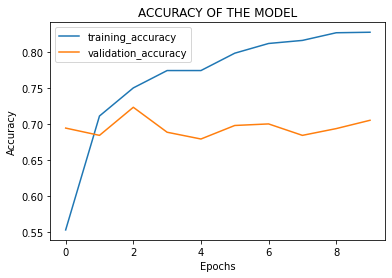

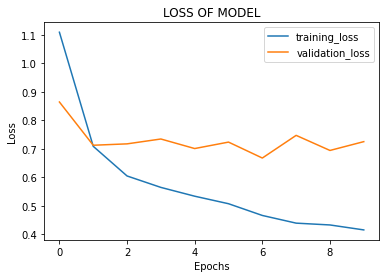

44/44 [==============================] - 5s 79ms/step


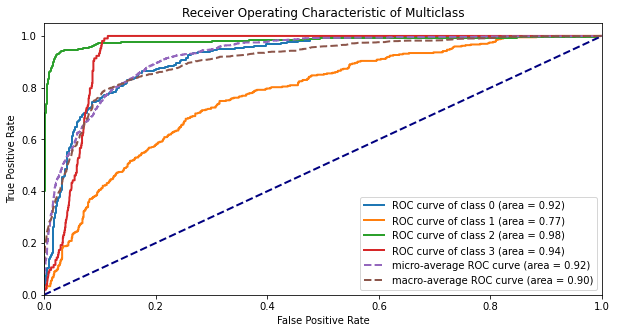

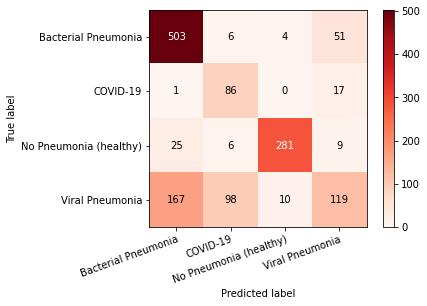

                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.72      0.89      0.80       564
              COVID-19       0.44      0.83      0.57       104
No Pneumonia (healthy)       0.95      0.88      0.91       321
       Viral Pneumonia       0.61      0.30      0.40       394

              accuracy                           0.72      1383
             macro avg       0.68      0.72      0.67      1383
          weighted avg       0.72      0.72      0.70      1383



In [33]:
##------ Accuracy plot for VGG16 TL model 
plot_acc_loss(tl_trained)

##----Getting prediction based in the VGG16 TL model
y_pred = tl_model.predict(X_test) 

#-------Plot ROC of the VGG16 TL model
plot_ROC_curve(y_pred,y_test_onehot,num_classes)

##----CM Matrix plot for VGG16 TL Model
plot_cm(label_map,y_pred,y_test)

#precision and recall and f1-score, accuracy 
table_p_r_f1(y_test,y_pred,label_map)

### 4.2 ResNet50

#### 4.2.1 Transfer learning with ResNet50

A ResNet model is used with a base on the previously tuned model. This model includes ResNet blocks that are used to help the model learn features by allowing information to bypass convolutional layers. 

In [34]:
# TUNED MODEL 1: BASELINE + LR SCHEDULER + KFOLD VALIDATION + EARLY STOPPING + LeakyReLU (gridsearch for alpha) + L2 regularizer
# FAILED CHANGES VS BASELINE INDICATED WITH A HASHTAG

RN50_model = build_h_model()

RN50_model.summary()

# Train the model for 10 epochs with a batch size of 32
res_history = RN50_model.fit(
    X_train,
    y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val_onehot))

Model: "h_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 156, 156, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 156, 156, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 156, 156, 32  18464       ['conv2d_44[0][0]']              
                                )                                                           

#### 4.2.2 Analyze performance of ResNet50 transfer learning model

The performance of the ResNet model is analysed in the plots below. The plot of accuracy and loss by epochs of training vs validation. Given the precision of the target variable, plot of ROC curve with its respective areas. The plot of the confusion matrix. Also, a table of the precision, recall and f1-score, and accuracy. 

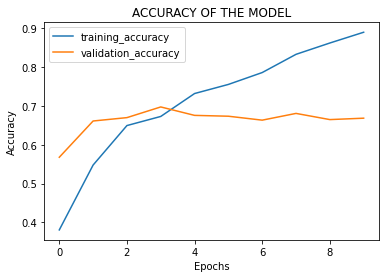

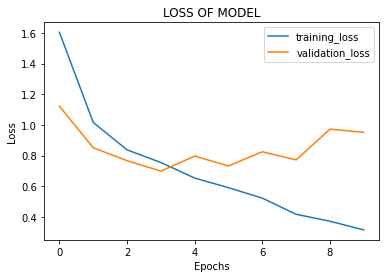

44/44 [==============================] - 2s 38ms/step


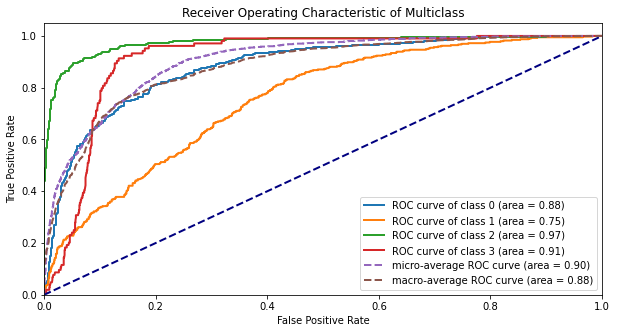

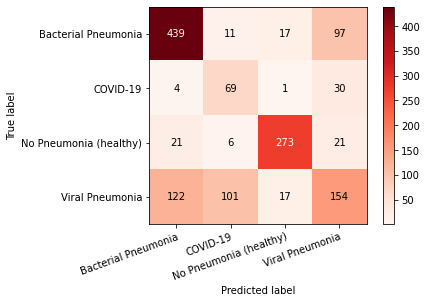

                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.75      0.78      0.76       564
              COVID-19       0.37      0.66      0.47       104
No Pneumonia (healthy)       0.89      0.85      0.87       321
       Viral Pneumonia       0.51      0.39      0.44       394

              accuracy                           0.68      1383
             macro avg       0.63      0.67      0.64      1383
          weighted avg       0.68      0.68      0.67      1383



In [35]:
##------ Accuracy plot for VGG16 TL model 
plot_acc_loss(res_history)

##----Getting prediction based in the VGG16 TL model
y_pred = RN50_model.predict(X_test) 

#-------Plot ROC of the VGG16 TL model
plot_ROC_curve(y_pred,y_test_onehot,num_classes)

##----CM Matrix plot for VGG16 TL Model
plot_cm(label_map,y_pred,y_test)

#precision and recall and f1-score, accuracy 
table_p_r_f1(y_test,y_pred,label_map)

# 5. Cross-model performance comparison

Performance comparison will be done first by a plot with 4 subplots. First, the subplot (up to the left) is a comparison of the accuracy per epoch of each model in the validation set. Second, to its right, is a comparison of the loss of each model in the validation set. At the bottom is only the training set used, to the left is the accuracy and to the right is the loss. 

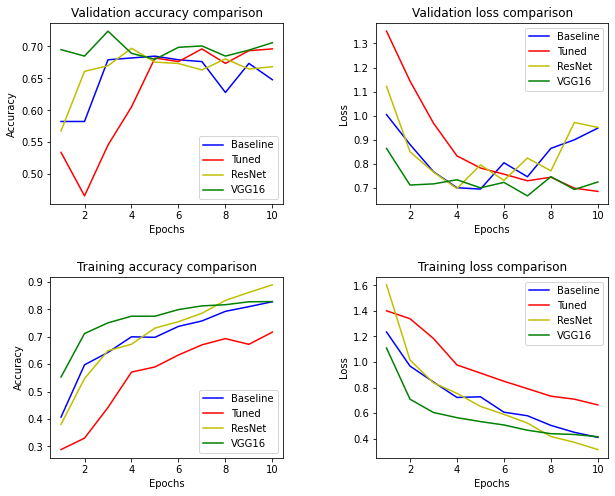

In [36]:
models_compared=[baseline_history, tuned_history, res_history, tl_trained]
name_models=['Baseline', 'Tuned', 'ResNet', "VGG16"]

plot_comparison_acc_loss(models_compared,name_models, num_epochs)